# Applications of Machine Learning Algorithms (Working with three models)

### Load libraries

In [105]:
%run ../services/imports.py
%run ../services/function.py
%run ../services/classifier_evaluation.py
%run ../services/visualization.py

In [106]:
visualizacao = Visualizacao()

## Load the database

In [3]:
dataset = pd.read_csv("../dados/df_poscomp.csv")

In [4]:
dataset["linhas_pesquisas"].value_counts()

linhas_pesquisas
inteligência artificial    3197
sistemas de computação     2254
engenharia de software     2016
Outros                     1280
redes de computadores      1146
Name: count, dtype: int64

In [5]:
dataset = dataset[(dataset["linhas_pesquisas"] != "Outros")]

In [6]:
X_dataset = dataset.loc[
    :,
    [
        "IDADE",
        "SEXO",
        "REGIAO",
        "ESTADO",
        "matematica",
        "fund_computacao",
        "tec_computacao",
        "total",
        "area_concentration",
    ],
]

In [7]:
X_dataset["area_concentration"] = dataset.area_concentration
X_dataset["area_concentration"] = X_dataset["area_concentration"].astype("category")

In [8]:
def encode_categorical_columns(df, columns):
    le = LabelEncoder()
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df


categorical_columns = ["area_concentration", "SEXO", "REGIAO", "ESTADO"]
X_dataset = encode_categorical_columns(X_dataset, categorical_columns)

In [9]:
X = X_dataset.drop(["area_concentration"], axis=1)
y = X_dataset["area_concentration"]

## Working with the first model

### Split the base

In [10]:
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [11]:
print("Shape of x_train : ", x_train.shape)
print("Shape of x_test  : ", x_test.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of y_test  : ", y_test.shape)

Shape of x_train :  (6029, 8)
Shape of x_test  :  (2584, 8)
Shape of y_train :  (6029,)
Shape of y_test  :  (2584,)


#### Turing hyperparameter

In [18]:
def process_cv_results(cv_results, top_n=10, output_filename="df_em_porcentagem.csv"):
    cv_results_df = pd.DataFrame(cv_results)

    # Classifique o DataFrame com base na pontuação do teste e no tempo
    cv_results_df = cv_results_df.sort_values(
        by=["mean_test_score", "mean_score_time"], ascending=[False, True]
    )

    # Remova as linhas duplicadas com base na pontuação do teste
    cv_results_df = cv_results_df.drop_duplicates(subset="mean_test_score", keep="first")

    # Selecione as melhores combinações
    param_col = [col for col in cv_results_df.columns if col.startswith("param")][:-1] + [
        "mean_test_score",
        "mean_train_score",
    ]
    cv_results_df = cv_results_df[param_col]
    top_results = cv_results_df.sort_values(by="mean_test_score", ascending=False)[:top_n]
    atributos = ["mean_test_score", "mean_train_score"]

    # Função para converter os valores para porcentagem
    def convert_to_percentage(value):
        return f"{value * 100:.2f}%"

    # Aplica a função de conversão a todas as células dos atributos selecionados e salva em um arquivo CSV
    top_results[atributos] = top_results[atributos].applymap(convert_to_percentage)
    top_results.to_csv(output_filename, index=False)

    return top_results


##### Árvore de Decisão

In [26]:
parametros = {
    "criterion": ["gini", "entropy"],
    "splitter": ["random", "best"],
    "max_depth": [4, 5, 7, 8],  # Ou qualquer outro intervalo apropriado
    "min_samples_split": [2, 5, 10, 15],
    "min_samples_leaf": [2, 3, 5, 9, 10],
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    "max_features": [5, 6, 7, 8, 9, 10],
    "max_leaf_nodes": [None, 5, 10, 14, 15, 16, 17],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],
    # 'ccp_alpha': [0.0, 0.1, 0.2],
}

In [27]:
tree_clf = ClassifierWrapper(DecisionTreeClassifier(random_state=42), parametros)
tree_clf.grid_search(x_train, y_train, cv=10)
tree_clf.train_and_print_scores(x_train, y_train, x_test, y_test)

Best Parameters:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 8, 'max_leaf_nodes': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'splitter': 'best'}
Best Score:
0.6598092042555771
Best Estimator:
DecisionTreeClassifier(max_depth=5, max_features=8, max_leaf_nodes=15,
                       min_samples_leaf=2, random_state=42)
Train Result:
Accuracy Score: 66.36%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.670806     0.616352  0.663626     0.643579      0.650818
recall        0.920073     0.221419  0.663626     0.570746      0.663626
f1-score      0.775912     0.325798  0.663626     0.550855      0.610693
support    3816.000000  2213.000000  0.663626  6029.000000   6029.000000
__________________________________________________________________________
Confusion Matrix: 
 [[3511  305]
 [1723  490]]

Test Result:
Accuracy Score: 67.34%


In [139]:
cv_results_df = pd.DataFrame(tree_clf.cv_results_)
# Suponha que 'time' seja o tempo de execução

# Classifique o DataFrame com base na pontuação do teste e no tempo
cv_results_df = cv_results_df.sort_values(
    by=["mean_test_score", "mean_score_time"], ascending=[False, True]
)

# Remova as linhas duplicadas com base na pontuação do teste
cv_results_df = cv_results_df.drop_duplicates(subset="mean_test_score", keep="first")

# Selecione as 20 melhores combinações
param_col = [col for col in cv_results_df.columns if col.startswith("param")][:-1] + [
    "mean_test_score",
    "mean_train_score",
]
cv_results_df = cv_results_df[param_col]
top_40 = cv_results_df.sort_values(by="mean_test_score", ascending=False)[:10]
atributos = ["mean_test_score", "mean_train_score"]


# Função para converter os valores para porcentagem
def convert_to_percentage(value):
    return f"{value * 100:.2f}%"  # Multiplica por 100 e formata como uma porcentagem com duas casas decimais


# Aplica a função de conversão a todas as células dos atributos selecionados e salva em um arquivo CSV
top_40[atributos] = top_40[atributos].applymap(convert_to_percentage)
top_40.to_csv("df_em_porcentagem.csv", index=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
3273,0.009721,0.001669,0.002115,0.000222,gini,5,10,15,10,2,...,0.662366,0.664025,0.664025,0.659049,0.659786,0.661813,0.661998,0.665193,0.662741,0.002001
3229,0.009309,0.000214,0.002093,0.000083,gini,5,10,14,9,10,...,0.662366,0.660523,0.664025,0.659049,0.657022,0.661813,0.661998,0.665193,0.662115,0.002517
9679,0.009369,0.000218,0.002110,0.000117,entropy,5,9,14,10,15,...,0.662366,0.658680,0.660339,0.659049,0.659049,0.658496,0.661998,0.662060,0.660861,0.001957
9969,0.009508,0.000355,0.002035,0.000194,entropy,5,10,15,3,2,...,0.662366,0.658680,0.664025,0.659049,0.659049,0.661813,0.661998,0.662060,0.661562,0.001961
9461,0.009565,0.000198,0.002095,0.000068,entropy,5,8,16,5,10,...,0.662366,0.662366,0.664025,0.659049,0.659049,0.661813,0.661998,0.662060,0.661930,0.001716
12503,0.009045,0.000370,0.001979,0.000194,entropy,8,7,15,5,15,...,0.662366,0.658680,0.660339,0.659049,0.657022,0.661813,0.661998,0.662060,0.661009,0.002212
11351,0.009218,0.000215,0.002043,0.000104,entropy,7,9,14,9,15,...,0.662366,0.658680,0.660339,0.659049,0.657022,0.658496,0.661998,0.662060,0.661009,0.002617
6093,0.010032,0.000799,0.002063,0.000077,gini,8,8,16,3,10,...,0.663288,0.668264,0.664025,0.659786,0.659786,0.661813,0.661998,0.665193,0.663681,0.002813
6055,0.009579,0.000210,0.002063,0.000064,gini,8,8,15,3,15,...,0.662366,0.664762,0.664025,0.659786,0.657022,0.661813,0.661998,0.665193,0.662962,0.002914
13115,0.009573,0.000352,0.002010,0.000062,entropy,8,9,16,10,5,...,0.662366,0.658680,0.664025,0.659049,0.659049,0.661813,0.661998,0.662060,0.661912,0.002264


In [143]:
top_40 = cv_results_df.sort_values(by="mean_test_score", ascending=False)[:10]

In [144]:
top_40.to_csv("df.csv")

In [145]:
atributos = ["mean_test_score", "mean_train_score"]


# Função para converter os valores para porcentagem
def convert_to_percentage(value):
    return f"{value * 100:.2f}%"  # Multiplica por 100 e formata como uma porcentagem com duas casas decimais


# Aplica a função de conversão a todas as células dos atributos selecionados e salva em um arquivo CSV
top_40[atributos] = top_40[atributos].applymap(convert_to_percentage)
top_40.to_csv("df_em_porcentagem.csv", index=False)

In [150]:
cv_results_df.shape[0]

804

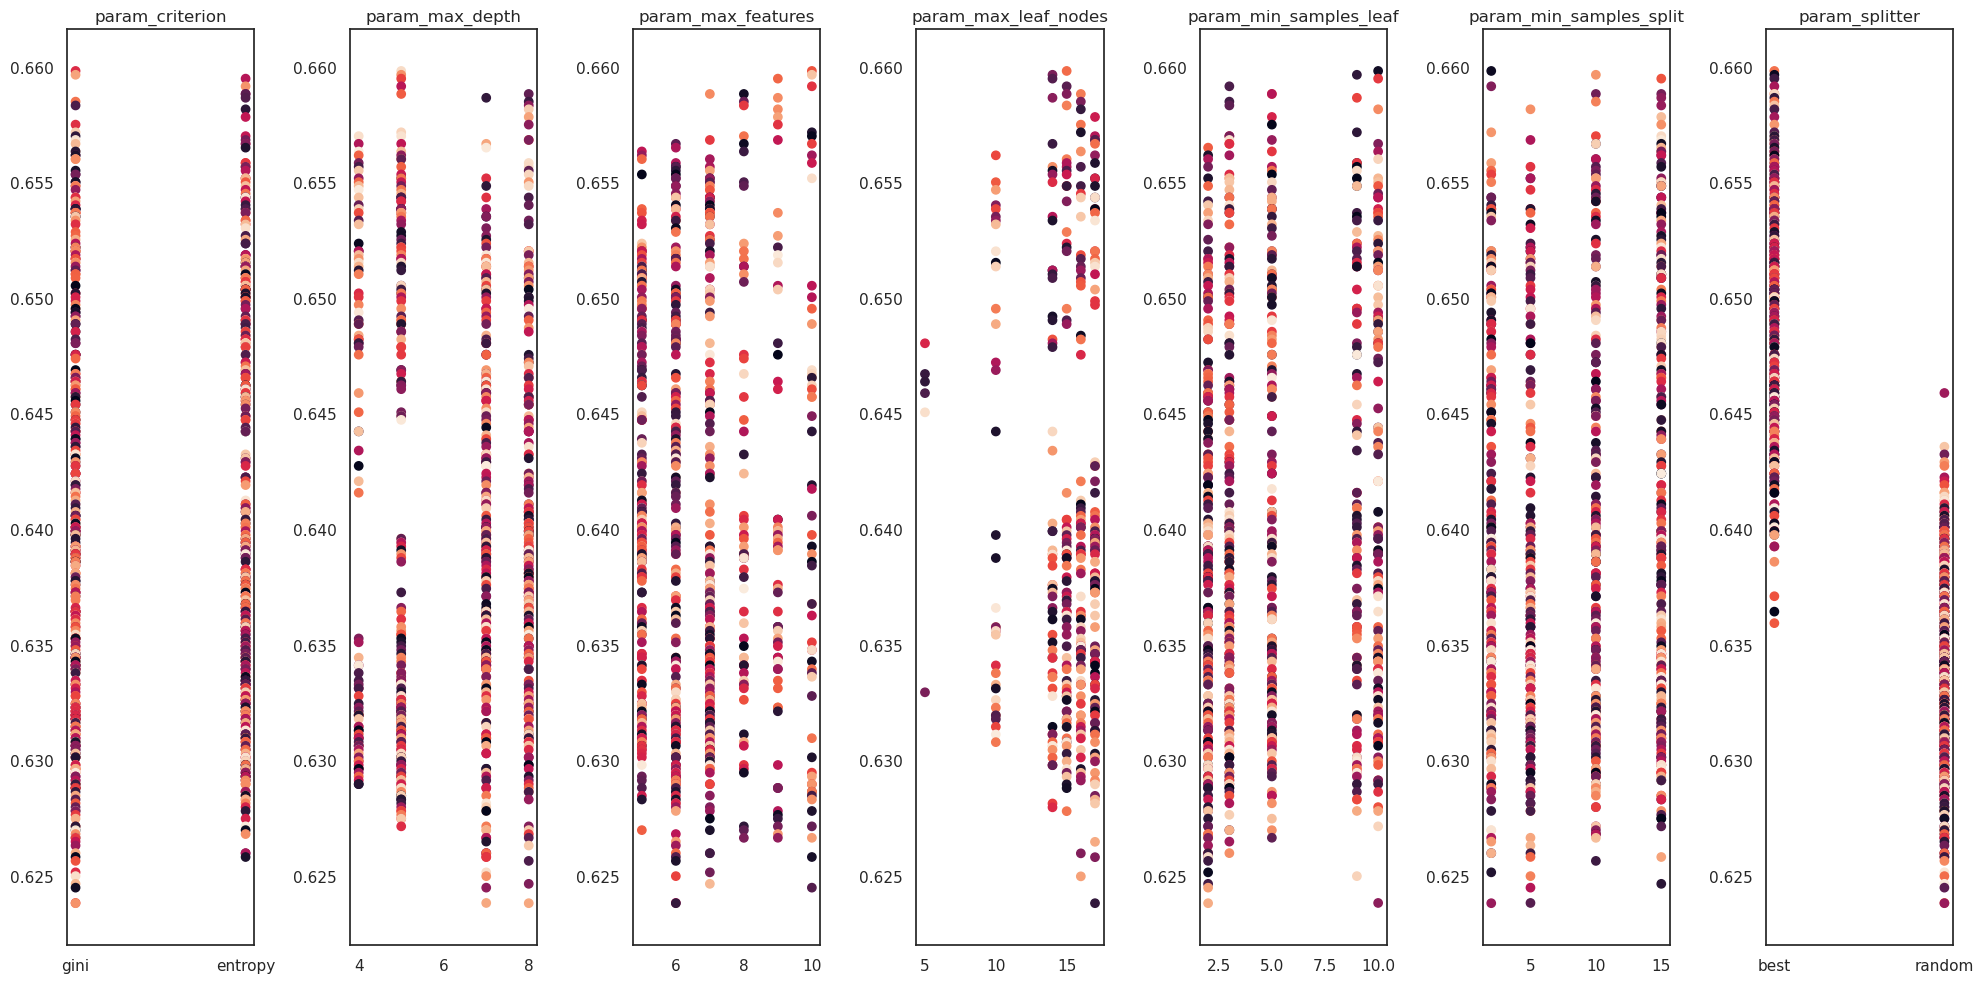

In [177]:
# Cria uma figura e eixos para os subplots
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(20, 10))

# Cria um scatter plot para cada coluna
# colors = np.random.rand(len(cv_results_df))  # Gerar cores aleatórias para cada ponto
for ax, column in zip(axs.flatten(), cv_results_df.columns):
    colors = np.random.rand(len(cv_results_df))  # Gerar cores aleatórias para cada ponto
    ax.scatter(y=cv_results_df['mean_test_score'], x=cv_results_df[column], c=colors)
    ax.set_title(f"{column}")

   # Adiciona uma barra de cores
plt.tight_layout()
plt.show()

In [169]:
# Import the library
import plotly.express as px

# Load the iris dataset provided by the library
# Create the chart:
fig = px.parallel_coordinates(
    cv_results_df, 
    color="species_id", 
    labels={"species_id": "Species","sepal_width": "Sepal Width", "sepal_length": "Sepal Length", "petal_width": "Petal Width", "petal_length": "Petal Length", },
    color_continuous_scale=px.colors.diverging.Tealrose,
    color_continuous_midpoint=2)

# Hide the color scale that is useless in this case
fig.update_layout(coloraxis_showscale=False)

# Show the plot
fig.show()

ModuleNotFoundError: No module named 'plotly'

##### Rede Neural

In [13]:
parametros = {
    "hidden_layer_sizes": [
        (50,),
        (100,),
        (50, 50),
        (100, 100),
        (500, 250, 125),
        (200, 100, 50),
    ],  # Experimente diferentes configurações de camadas e neurônios
    "activation": ["identity", "logistic", "tanh", "relu"],
    "solver": ["lbfgs", "sgd", "adam"],
    "alpha": [0.0001, 0.001, 0.01],
    "batch_size": [100, 200, 300],
    # 'learning_rate': ['invscaling'],
    # 'learning_rate_init': [0.001, 0.01, 0.1],
    # 'power_t': [0.5, 0.9],
    "max_iter": [100, 200],
    # 'shuffle': [True, False],
    # 'random_state': [None, 42],
    # 'tol': [1e-4, 1e-3, 1e-2],
    # 'verbose': [True, False],
    # 'warm_start': [True, False],
    # 'momentum': [0.5, 0.9],
    # 'nesterovs_momentum': [True, False],
    # 'early_stopping': [True, False],
    # 'validation_fraction': [0.1, 0.2],
    # 'beta_1': [0.9, 0.99],
    # 'beta_2': [0.999, 0.9999],
    # 'epsilon': [1e-8, 1e-7],
    # 'n_iter_no_change': [5, 10, 15],
    # 'max_fun': [10000, 15000, 20000]
}

In [14]:
neural_clf = ClassifierWrapper(MLPClassifier(random_state=42), parametros)
neural_clf.grid_search(x_train, y_train, cv=3)
neural_clf.train_and_print_scores(x_train, y_train, x_test, y_test)

/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

Best Parameters:
{'activation': 'logistic', 'alpha': 0.0001, 'batch_size': 100, 'hidden_layer_sizes': (100,), 'max_iter': 100, 'solver': 'lbfgs'}
Best Score:
0.6384144484149684
Best Estimator:
MLPClassifier(activation='logistic', batch_size=100, max_iter=100,
              random_state=42, solver='lbfgs')
Train Result:
Accuracy Score: 64.11%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.654162     0.536513  0.641068     0.595337      0.610978
recall        0.918501     0.162675  0.641068     0.540588      0.641068
f1-score      0.764116     0.249653  0.641068     0.506885      0.575278
support    3816.000000  2213.000000  0.641068  6029.000000   6029.000000
__________________________________________________________________________
Confusion Matrix: 
 [[3505  311]
 [1853  360]]

Test Result:
Accuracy Score: 63.97%
__________________________________

In [27]:
process_cv_results(neural_clf.cv_results_, top_n=10, output_filename='df_em_porcentagem_neural.csv')

,param_activation,param_alpha,param_batch_size,param_hidden_layer_sizes,param_max_iter,param_solver,mean_test_score,mean_train_score
402,logistic,0.0001,300,"(100,)",100,lbfgs,63.84%,65.09%
510,logistic,0.001,300,"(100,)",100,lbfgs,63.64%,65.20%
407,logistic,0.0001,300,"(100,)",200,adam,63.61%,63.77%
932,tanh,0.01,200,"(200, 100, 50)",100,adam,63.59%,66.83%
500,logistic,0.001,200,"(200, 100, 50)",100,adam,63.58%,63.20%
515,logistic,0.001,300,"(100,)",200,adam,63.58%,63.79%
464,logistic,0.001,100,"(200, 100, 50)",100,adam,63.53%,63.89%
623,logistic,0.01,300,"(100,)",200,adam,63.51%,63.63%
503,logistic,0.001,200,"(200, 100, 50)",200,adam,63.49%,63.14%
371,logistic,0.0001,200,"(100,)",200,adam,63.46%,63.70%


##### Random Forest

In [21]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy="majority")
x_under, y_under = tl.fit_resample(X, y)
x_train_u, x_test_u, y_train_u, y_test_u = train_test_split(
    x_under, y_under, test_size=0.3, stratify=y_under
)

In [28]:
parametros = {
    "n_estimators": [100,200,300],  # Você pode ajustar o número de árvores conforme necessário
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [9, 10, 12],
    'min_samples_split': [2, 5,10],
    "min_samples_leaf": [2,4,6],
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    "max_features": [5,6,7],
    # 'max_leaf_nodes': [None, 10, 20, 30],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],
    'bootstrap': [False],
    # 'oob_score': [True, False],
    # 'n_jobs': [-1],  # Use -1 para usar todos os processadores disponíveis
    # 'random_state': [None, 42],  # Use um valor fixo para repetibilidade
    # 'verbose': [0, 1, 2],
    # 'warm_start': [True, False],
    # 'class_weight': [None, 'balanced', 'balanced_subsample'],
    # 'ccp_alpha': [0.0, 0.1, 0.2],
    # 'max_samples': [None, 0.7, 0.8, 0.9],
}

In [29]:
forest_clf = ClassifierWrapper(RandomForestClassifier(random_state=42), parametros)
forest_clf.grid_search(x_train, y_train, cv=10)
forest_clf.train_and_print_scores(x_train, y_train, x_test, y_test)

Best Parameters:
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'max_features': 6, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
Best Score:
0.6571552536321713
Best Estimator:
RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=9,
                       max_features=6, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=200, random_state=42)
Train Result:
Accuracy Score: 74.22%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.745017     0.733192  0.742246     0.739105      0.740677
recall        0.901205     0.468143  0.742246     0.684674      0.742246
f1-score      0.815702     0.571429  0.742246     0.693565      0.726039
support    3816.000000  2213.000000  0.742246  6029.000000   6029.000000
__________________________________________________________________________
C

In [30]:
process_cv_results(forest_clf.cv_results_, top_n=10, output_filename='df_em_porcentagem_rf.csv')

,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,mean_train_score
274,False,entropy,9,6,2,5,200,65.72%,74.72%
518,False,log_loss,9,6,2,5,300,65.62%,74.73%
243,False,entropy,9,5,2,2,100,65.58%,75.17%
273,False,entropy,9,6,2,5,100,65.55%,74.76%
278,False,entropy,9,6,2,10,300,65.55%,74.04%
260,False,entropy,9,5,4,10,300,65.55%,74.34%
259,False,entropy,9,5,4,10,200,65.55%,74.32%
488,False,log_loss,9,5,2,2,300,65.53%,75.11%
258,False,entropy,9,5,4,10,100,65.52%,74.38%
295,False,entropy,9,6,6,10,200,65.50%,73.76%


##### SVM

In [36]:
parametros = {
    "C": [20, 30, 40, 50],
    'kernel': ['rbf', 'poly'],
    "degree": [1, 2, 3],
    # "gamma": ["scale", "auto", 0.1, 1.0],
    # 'coef0': [0.0, 0.1, 1.0],
    # 'shrinking': [True, False],
    # 'probability': [True],
    # 'tol': [1e-4],
    # 'cache_size': np.arange(1,11,2),
    # "class_weight": ["balanced"],
    # 'verbose': [True],
    # 'max_iter': [100, 1000, -1],  # -1 indica nenhum limite
    # 'decision_function_shape': ['ovr', 'ovo'],
    # 'break_ties': [True],
}

In [37]:
svm_clf = ClassifierWrapper(SVC(random_state=42), parametros)
svm_clf.grid_search(x_train, y_train, cv=10)
svm_clf.train_and_print_scores(x_train, y_train, x_test, y_test)

Best Parameters:
{'C': 20, 'degree': 1, 'kernel': 'rbf'}
Best Score:
0.6329407778383829
Best Estimator:
SVC(C=20, degree=1, random_state=42)
Train Result:
Accuracy Score: 63.29%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0       1  accuracy    macro avg  weighted avg
precision     0.632941     0.0  0.632941     0.316470      0.400614
recall        1.000000     0.0  0.632941     0.500000      0.632941
f1-score      0.775216     0.0  0.632941     0.387608      0.490666
support    3816.000000  2213.0  0.632941  6029.000000   6029.000000
__________________________________________________________________________
Confusion Matrix: 
 [[3816    0]
 [2213    0]]

Test Result:
Accuracy Score: 63.27%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0      1  accuracy    macro avg  weighted avg
precision     0.632740    0.0   0.63274     0.316370      0.

In [88]:
process_cv_results(svm_clf.cv_results_, top_n=10, output_filename='df_em_porcentagem_SVM.csv')

,param_C,param_degree,param_kernel,mean_test_score,mean_train_score
28,4,7,poly,67.42%,71.74%
20,3,7,poly,67.42%,71.42%
18,3,6,poly,67.28%,70.40%
30,4,8,poly,67.24%,72.37%
12,2,7,poly,67.24%,71.22%
26,4,6,poly,67.19%,70.67%
14,2,8,poly,67.06%,72.03%
6,1,8,poly,67.06%,71.64%
4,1,7,poly,66.97%,70.49%
22,3,8,poly,66.88%,72.32%


### Cross Validation

In [70]:
x_poscomp = np.concatenate((x_train, x_test), axis=0)
y_poscomp = np.concatenate((y_train, y_test), axis=0)

In [72]:
# Uso para Decision Tree
params_arvore = {
    "criterion": "gini",
    "max_depth": 5,
    "max_features": 10,
    "min_samples_leaf": 10,
    "splitter": "best",
    "random_state": 42,
    "max_leaf_nodes": 15,
}
resultados_arvore = ClassifierWrapper.avaliar_classificador(
    DecisionTreeClassifier, params_arvore, x_poscomp, y_poscomp
)

# Uso para Random Forest
params_random_forest = {
    "bootstrap": False,
    "criterion": "entropy",
    "max_depth": 10,
    "max_features": 6,
    "min_samples_leaf": 2,
    "n_estimators": 1000,
    "n_jobs": -1,
    "warm_start": True,
    "random_state": 42,
}
resultados_random_forest = ClassifierWrapper.avaliar_classificador(
    RandomForestClassifier, params_random_forest, x_poscomp, y_poscomp
)

# Uso para SVM
params_svm = {
    "C": 20,
    "degree": 1,
    "kernel":"rbf",
    "random_state": 42,
    "tol": 0.0001,
}
resultados_svm = ClassifierWrapper.avaliar_classificador(
    SVC, params_svm, x_poscomp, y_poscomp
)

# Uso para MLP (Rede Neural)
params_rede_neural = {
    "activation": "logistic",
    "alpha": 0.0001,
    "batch_size": 100,
    "hidden_layer_sizes": (100,),
    "max_iter": 100,
    "solver": "lbfgs",
    "random_state": 42,
}
resultados_rede_neural = ClassifierWrapper.avaliar_classificador(
    MLPClassifier, params_rede_neural, x_poscomp, y_poscomp
)

In [73]:
resultados = pd.DataFrame(
    {
        "decisionTree_treino": resultados_arvore[0]["train_score"],
        "decisionTree_teste": resultados_arvore[0]["test_score"],
        "randomForest_treino": resultados_random_forest[0]["train_score"],
        "randomForest_teste": resultados_random_forest[0]["test_score"],
        "svm_treino": resultados_svm[0]["train_score"],
        "svm_teste": resultados_svm[0]["test_score"],
        "redeNeural_treino": resultados_rede_neural[0]["train_score"],
        "redeNeural_teste": resultados_rede_neural[0]["test_score"],
    }
)

In [74]:
resultados

,decisionTree_treino,decisionTree_teste,randomForest_treino,randomForest_teste,svm_treino,svm_teste,redeNeural_treino,redeNeural_teste
0,0.656302,0.650812,0.763385,0.656613,0.632951,0.632251,0.651787,0.642691
1,0.664688,0.678654,0.760676,0.693735,0.633080,0.632251,0.643014,0.619490
2,0.666882,0.663573,0.758225,0.674014,0.632822,0.633411,0.647400,0.664733
3,0.657379,0.641115,0.753741,0.651568,0.632869,0.632985,0.646672,0.636469
4,0.664861,0.671312,0.752709,0.662021,0.632869,0.632985,0.640609,0.631823
5,0.667441,0.643438,0.763803,0.637631,0.632869,0.632985,0.643576,0.623693
6,0.666280,0.660859,0.767028,0.651568,0.632998,0.632985,0.642931,0.637631
7,0.666280,0.668990,0.766254,0.649245,0.632869,0.632985,0.638287,0.649245
8,0.667441,0.663182,0.776445,0.644599,0.632869,0.632985,0.643834,0.642276
9,0.667054,0.651568,0.764577,0.636469,0.632869,0.632985,0.646414,0.644599


In [75]:
resultados.var()

decisionTree_treino    1.709844e-05
decisionTree_teste     1.514050e-04
randomForest_treino    4.774388e-05
randomForest_teste     3.020252e-04
svm_treino             6.216352e-09
svm_teste              1.278865e-07
redeNeural_treino      1.439772e-05
redeNeural_teste       1.663223e-04
dtype: float64

In [76]:
(resultados.std() / resultados.mean()) * 100

decisionTree_treino    0.622313
decisionTree_teste     1.866181
randomForest_treino    0.905971
randomForest_teste     2.650243
svm_treino             0.012457
svm_teste              0.056505
redeNeural_treino      0.588784
redeNeural_teste       2.017410
dtype: float64

In [77]:
medias = resultados.mean()
for nome_coluna, media in medias.items():
    print(f"Média da {nome_coluna}: {media * 100:.2f}%")

Média da decisionTree_treino: 66.45%
Média da decisionTree_teste: 65.94%
Média da randomForest_treino: 76.27%
Média da randomForest_teste: 65.57%
Média da svm_treino: 63.29%
Média da svm_teste: 63.29%
Média da redeNeural_treino: 64.45%
Média da redeNeural_teste: 63.93%


In [78]:
resultados_teste = resultados.loc[
    :, ["decisionTree_teste", "randomForest_teste", "svm_teste", "redeNeural_teste"]
]

In [79]:
resultados_teste.columns = ["Árvore de Decisão", "Random Forest", "SVM", "Rede Neural"]

In [80]:
resultados_teste

,Árvore de Decisão,Random Forest,SVM,Rede Neural
0,0.650812,0.656613,0.632251,0.642691
1,0.678654,0.693735,0.632251,0.619490
2,0.663573,0.674014,0.633411,0.664733
3,0.641115,0.651568,0.632985,0.636469
4,0.671312,0.662021,0.632985,0.631823
5,0.643438,0.637631,0.632985,0.623693
6,0.660859,0.651568,0.632985,0.637631
7,0.668990,0.649245,0.632985,0.649245
8,0.663182,0.644599,0.632985,0.642276
9,0.651568,0.636469,0.632985,0.644599


In [81]:
resultados_treino = resultados.loc[
    :, ["decisionTree_treino", "randomForest_treino", "svm_treino", "redeNeural_treino"]
]

In [82]:
resultados_treino

,decisionTree_treino,randomForest_treino,svm_treino,redeNeural_treino
0,0.656302,0.763385,0.632951,0.651787
1,0.664688,0.760676,0.633080,0.643014
2,0.666882,0.758225,0.632822,0.647400
3,0.657379,0.753741,0.632869,0.646672
4,0.664861,0.752709,0.632869,0.640609
5,0.667441,0.763803,0.632869,0.643576
6,0.666280,0.767028,0.632998,0.642931
7,0.666280,0.766254,0.632869,0.638287
8,0.667441,0.776445,0.632869,0.643834
9,0.667054,0.764577,0.632869,0.646414


In [83]:
resultados_treino.columns = ["Árvore de Decisão", "Random Forest", "SVM", "Rede Neural"]

In [84]:
resultados_treino.mean()

Árvore de Decisão    0.664461
Random Forest        0.762684
SVM                  0.632906
Rede Neural          0.644452
dtype: float64

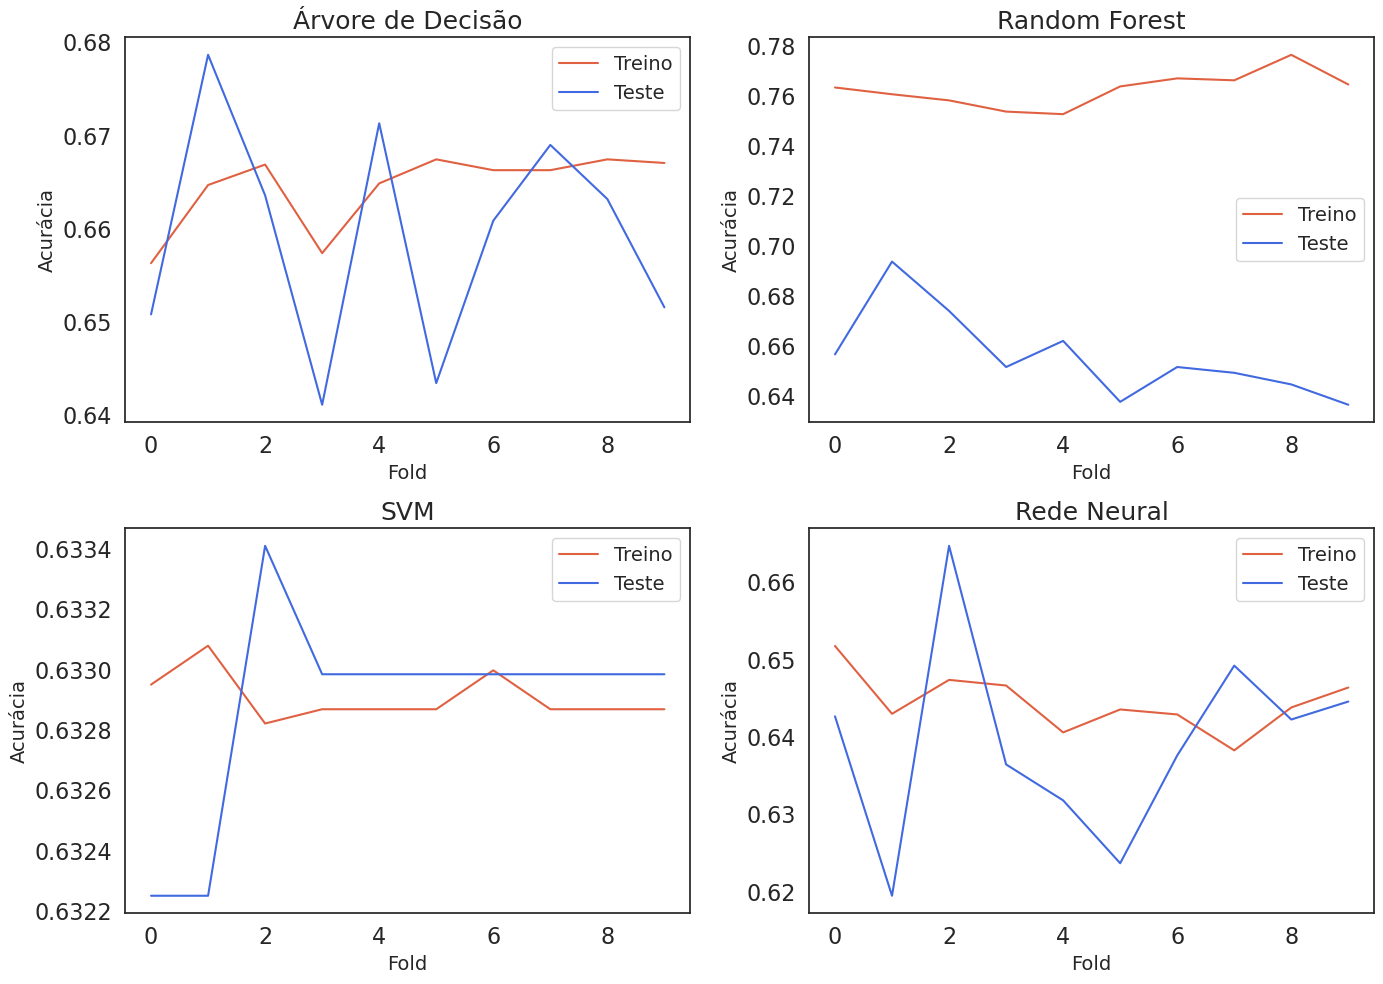

In [107]:
models = ["decisionTree", "randomForest", "svm", "redeNeural"]
models_nome = ["Árvore de Decisão", "Random Forest", "SVM", "Rede Neural"]
visualizacao.plot_learning_curve(
    resultados,
    models=models,
    model_names=models_nome,
    save_path="../imagens/curva_aprendizadoML0.pdf",
)

#### Teste de normalidade

In [ ]:
alpha = 0.05

In [ ]:
from scipy.stats import shapiro

In [ ]:
shapiro(resultados_arvore[0]["test_score"]), shapiro(
    resultados_random_forest[0]["test_score"]
), shapiro(resultados_svm[0]["test_score"]), shapiro(
    resultados_rede_neural[0]["test_score"]
)

#### Teste de hipótese com ANOVA e Tukey

In [ ]:
from scipy.stats import f_oneway

In [ ]:
_, p = f_oneway(
    resultados_arvore[0]["test_score"],
    resultados_random_forest[0]["test_score"],
    resultados_svm[0]["test_score"],
    resultados_rede_neural[0]["test_score"],
)
p

In [ ]:
alpha = 0.05
if p <= alpha:
    print("Hipótese nula rejeitada. Dados são diferentes")
else:
    print("Hipótese alternativa rejeitada. Resultados são iguais")

In [ ]:
resultados_algoritmos = {
    "accuracy": np.concatenate(
        [
            resultados_arvore[0]["test_score"],
            resultados_random_forest[0]["test_score"],
            resultados_svm[0]["test_score"],
            resultados_rede_neural[0]["test_score"],
        ]
    ),
    "algoritmo": ["arvore"] * len(resultados_arvore[0]["test_score"])
    + ["random_forest"] * len(resultados_random_forest[0]["test_score"])
    + ["svm"] * len(resultados_svm[0]["test_score"])
    + ["rede_neural"] * len(resultados_rede_neural[0]["test_score"]),
}

In [ ]:
resultados_df = pd.DataFrame(resultados_algoritmos)
resultados_df.head()

In [ ]:
from statsmodels.stats.multicomp import MultiComparison

In [ ]:
compara_algoritmos = MultiComparison(
    resultados_df["accuracy"], resultados_df["algoritmo"]
)

In [ ]:
teste_estatistico = compara_algoritmos.tukeyhsd()
print(teste_estatistico)

In [ ]:
resultados_teste.mean()

In [ ]:
teste_estatistico.plot_simultaneous();

#### Salvar o classificador treinado

In [ ]:
classificador_randomForest = RandomForestClassifier(
    bootstrap=False,
    criterion="entropy",
    max_depth=10,
    n_estimators=1000,
    n_jobs=-1,
    random_state=42,
    max_features=6,
    min_samples_leaf=2,
    warm_start=True,
)
classificador_randomForest.fit(x_train, y_train)

In [ ]:
predict = classificador_randomForest.predict(x_test)

In [ ]:
from sklearn.metrics import auc, roc_curve

fpr, tpr, thresholds = roc_curve(y_test, predict)

# Calcule a área sob a curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Plote a curva ROC
plt.figure(figsize=(8, 8))
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=2,
    label="ROC curve (area = {:.2f})".format(roc_auc),
)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [ ]:
with open("dados/classificadores/randomForest_finalizado2.sav", "wb") as file:
    pickle.dump(classificador_randomForest, file, protocol=pickle.HIGHEST_PROTOCOL)

#### Carregar um classificar treinado

In [ ]:
randomForest = pickle.load(open("randomForest_finalizado.sav", "rb"))

## Applications of the two models

### Candidates classified for the computing area

<h4> <i>Load data </i></h4>

In [38]:
df_computation = dataset[dataset["area_concentration"] == "computacao"]

In [39]:
df_computation = df_computation.loc[
    :,
    [
        "IDADE",
        "SEXO",
        "REGIAO",
        "ESTADO",
        "matematica",
        "fund_computacao",
        "tec_computacao",
        "total",
        "linhas_pesquisas",
    ],
]

In [40]:
categorical_columns_comp = ["linhas_pesquisas", "SEXO", "REGIAO", "ESTADO"]
df_computation = encode_categorical_columns(df_computation, categorical_columns_comp)

In [41]:
x_computation = df_computation.drop(["linhas_pesquisas"], axis=1)
y_computation = df_computation["linhas_pesquisas"]

<h5><i>Split of data</i></h5>

In [42]:
x_train_comp, x_test_comp, y_train_comp, y_test_comp = train_test_split(
    x_computation, y_computation, test_size=0.3, stratify=y_computation, random_state=42
)

In [43]:
print("Shape of x_train : ", x_train_comp.shape)
print("Shape of x_test  : ", x_test_comp.shape)
print("Shape of y_train : ", y_train_comp.shape)
print("Shape of y_test  : ", y_test_comp.shape)

Shape of x_train :  (3815, 8)
Shape of x_test  :  (1636, 8)
Shape of y_train :  (3815,)
Shape of y_test  :  (1636,)


##### Busca por hiperparamentros

###### Decision Tree

In [119]:
parametros = {
    "criterion": ["gini", "entropy", "log_loss"],
    "splitter": ["random", "best"],
    "max_depth": [8,9,10],  # Ou qualquer outro intervalo apropriado
    'min_samples_split': [2,5],
    "min_samples_leaf": [9,10,11],
    # 'min_weight_fraction_leaf': [0.5],
    "max_features": [7,8,9],
    "max_leaf_nodes": [15,20,25],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],
    # 'ccp_alpha': [0.0, 0.1, 0.2],
}

In [120]:
tree_clf = ClassifierWrapper(DecisionTreeClassifier(random_state=42), parametros)
tree_clf.grid_search(x_train_comp, y_train_comp, cv=10)
tree_clf.train_and_print_scores(x_train_comp, y_train_comp, x_test_comp, y_test_comp)

Best Parameters:
{'criterion': 'gini', 'max_depth': 9, 'max_features': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}
Best Score:
0.6941020461447553
Best Estimator:
DecisionTreeClassifier(max_depth=9, max_features=8, max_leaf_nodes=20,
                       min_samples_leaf=10, random_state=42, splitter='random')
Train Result:
Accuracy Score: 70.69%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.701042     0.722868  0.706946     0.711955      0.710070
recall        0.872150     0.472750  0.706946     0.672450      0.706946
f1-score      0.777291     0.571648  0.706946     0.674469      0.692231
support    2237.000000  1578.000000  0.706946  3815.000000   3815.000000
__________________________________________________________________________
Confusion Matrix: 
 [[1951  286]
 [ 832  746]]

Test Result:


In [122]:
process_cv_results(tree_clf.cv_results_, top_n=10, output_filename="df_em_porcents_treeM1.csv")

,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_splitter,mean_test_score,mean_train_score
160,gini,9,8,20,10,2,random,69.41%,70.24%
54,gini,8,8,20,10,5,random,69.33%,70.26%
35,gini,8,7,25,11,5,best,69.31%,71.51%
141,gini,9,7,25,11,2,best,69.25%,71.55%
235,gini,10,7,20,10,5,best,69.25%,71.15%
46,gini,8,8,15,11,5,random,69.25%,69.78%
166,gini,9,8,20,11,5,random,69.25%,70.08%
172,gini,9,8,25,10,2,random,69.23%,70.56%
231,gini,10,7,20,9,5,best,69.20%,71.17%
502,entropy,9,8,25,11,5,random,69.20%,70.31%


###### Random Forest

In [125]:
parametros = {
    "n_estimators": [200, 300, 500],
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [4, 5, 6],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [7, 8, 9],
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    "max_features": [7, 8, 9],
    "max_leaf_nodes": [10, 20, 30],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],
    "bootstrap": [True, False],
    # "oob_score": [True],
    "n_jobs": [-1],  # Use -1 para usar todos os processadores disponíveis
    # 'verbose': [0, 1, 2],
    # "warm_start": [True],
    # 'class_weight': ['balanced', 'balanced_subsample'],
    # 'ccp_alpha': [0.0, 0.1, 0.2],
    # 'max_samples': [1,2,3,4,5],
}

In [126]:
forest_clf = ClassifierWrapper(RandomForestClassifier(random_state=42), parametros)
forest_clf.grid_search(x_train_comp, y_train_comp, cv=10)
forest_clf.train_and_print_scores(x_train_comp, y_train_comp, x_test_comp, y_test_comp)

Best Parameters:
{'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'max_features': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 9, 'min_samples_split': 2, 'n_estimators': 300, 'n_jobs': -1}
Best Score:
0.7071999835099148
Best Estimator:
RandomForestClassifier(max_depth=5, max_features=7, max_leaf_nodes=30,
                       min_samples_leaf=9, n_estimators=300, n_jobs=-1,
                       random_state=42)
Train Result:
Accuracy Score: 72.45%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.705903     0.781818  0.724509     0.743860      0.737304
recall        0.908806     0.463245  0.724509     0.686026      0.724509
f1-score      0.794606     0.581775  0.724509     0.688190      0.706573
support    2237.000000  1578.000000  0.724509  3815.000000   3815.000000
_________________________________________________________________________

In [127]:
process_cv_results(forest_clf.cv_results_, top_n=10, output_filename="df_em_porcents_forestM1.csv")

,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_n_estimators,param_n_jobs,mean_test_score,mean_train_score
322,True,gini,5,7,30,9,6,300,-1,70.72%,72.51%
310,True,gini,5,7,30,8,4,300,-1,70.67%,72.55%
314,True,gini,5,7,30,8,6,500,-1,70.62%,72.60%
389,True,gini,5,8,30,8,2,500,-1,70.62%,72.73%
320,True,gini,5,7,30,9,4,500,-1,70.62%,72.59%
557,True,gini,6,7,30,8,6,500,-1,70.62%,72.98%
383,True,gini,5,8,30,7,4,500,-1,70.59%,72.75%
514,True,gini,6,7,20,7,2,300,-1,70.59%,72.23%
285,True,gini,5,7,20,8,6,200,-1,70.56%,72.09%
1900,True,log_loss,5,9,20,8,2,300,-1,70.56%,72.00%


###### SVM

In [132]:
parametros = {
    "C": [0.1,1,2,3,4],
    'kernel': ['rbf', 'poly'],
    "degree": [1, 2, 3],
    # "gamma": ["scale", "auto", 0.1, 1.0],
    # 'coef0': [0.0, 0.1, 1.0],
    # 'shrinking': [True, False],
    # 'probability': [True],
    # 'tol': [1e-4],
    # 'cache_size': np.arange(1,11,2),
    # "class_weight": ["balanced"],
    # 'verbose': [True],
    # 'max_iter': [100, 1000, -1],  # -1 indica nenhum limite
    # 'decision_function_shape': ['ovr', 'ovo'],
    # 'break_ties': [True],
}

In [133]:
svm_clf = ClassifierWrapper(SVC(random_state=42), parametros)
svm_clf.grid_search(x_train_comp, y_train_comp, cv=10)
svm_clf.train_and_print_scores(x_train_comp, y_train_comp, x_test_comp, y_test_comp)

Best Parameters:
{'C': 2, 'degree': 2, 'kernel': 'poly'}
Best Score:
0.6597586950845804
Best Estimator:
SVC(C=2, degree=2, kernel='poly', random_state=42)
Train Result:
Accuracy Score: 66.40%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.687475     0.616719  0.663958     0.652097      0.658209
recall        0.782745     0.495564  0.663958     0.639154      0.663958
f1-score      0.732023     0.549543  0.663958     0.640783      0.656544
support    2237.000000  1578.000000  0.663958  3815.000000   3815.000000
__________________________________________________________________________
Confusion Matrix: 
 [[1751  486]
 [ 796  782]]

Test Result:
Accuracy Score: 67.85%
__________________________________________________________________________
CLASSIFICATION REPORT:
                    0           1  accuracy    macro avg  weighted avg
precision    0.70

In [134]:
process_cv_results(svm_clf.cv_results_, top_n=10, output_filename="df_em_porcents_svmM1.csv")

,param_C,param_degree,param_kernel,mean_test_score,mean_train_score
15,2,2,poly,65.98%,66.20%
25,4,1,poly,65.90%,66.14%
27,4,2,poly,65.87%,66.36%
21,3,2,poly,65.84%,66.30%
9,1,2,poly,65.77%,66.08%
19,3,1,poly,65.74%,66.06%
17,2,3,poly,65.69%,66.58%
29,4,3,poly,65.56%,66.63%
13,2,1,poly,65.50%,65.72%
23,3,3,poly,65.48%,66.59%


###### Rede Neural

In [130]:
parametros = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100), (200, 100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    "solver": ["adam"],
    "alpha": [0.1],
    "batch_size": ["auto", 100, 200],
    # 'learning_rate': ['constant', 'invscaling', 'adaptive'],
    "learning_rate_init": [0.01],
    # 'power_t': [0.5, 0.9],
    # 'max_iter': [200, 300, 400],
    # 'shuffle': [True, False],
    # 'random_state': [None, 42],
    # 'tol': [1e-4, 1e-3, 1e-2],
    # 'verbose': [True, False],
    # 'warm_start': [True, False],
    # 'momentum': [0.5, 0.9],
    # 'nesterovs_momentum': [True, False],
    "early_stopping": [True, False],
    # 'validation_fraction': [0.1, 0.2],
    "beta_1": [0.99],
    "beta_2": [0.999],
    "epsilon": [1e-8],
    "n_iter_no_change": [20],
    # 'max_fun': [10000, 15000, 20000]
}

In [131]:
neural_clf = ClassifierWrapper(
    MLPClassifier(random_state=42), parametros
)
neural_clf.grid_search(x_train_comp, y_train_comp, cv=10)
neural_clf.train_and_print_scores(x_train_comp, y_train_comp, x_test_comp, y_test_comp)

/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warning

Best Parameters:
{'activation': 'relu', 'alpha': 0.1, 'batch_size': 100, 'beta_1': 0.99, 'beta_2': 0.999, 'early_stopping': False, 'epsilon': 1e-08, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'n_iter_no_change': 20, 'solver': 'adam'}
Best Score:
0.6906961564359428
Best Estimator:
MLPClassifier(alpha=0.1, batch_size=100, beta_1=0.99,
              hidden_layer_sizes=(100, 100), learning_rate_init=0.01,
              n_iter_no_change=20, random_state=42)
Train Result:
Accuracy Score: 68.34%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.693639     0.659758  0.683355     0.676699      0.679625
recall        0.823871     0.484157  0.683355     0.654014      0.683355
f1-score      0.753167     0.558480  0.683355     0.655823      0.672638
support    2237.000000  1578.000000  0.683355  3815.000000   3815.000000
________________________

In [135]:
process_cv_results(neural_clf.cv_results_, top_n=10, output_filename="df_em_porcents_neuralM1.csv")

,param_activation,param_alpha,param_batch_size,param_beta_1,param_beta_2,param_early_stopping,param_epsilon,param_hidden_layer_sizes,param_learning_rate_init,param_n_iter_no_change,param_solver,mean_test_score,mean_train_score
108,relu,0.1,100,0.99,0.999,False,0.0,"(100, 100)",0.01,20,adam,69.07%,69.45%
87,tanh,0.1,200,0.99,0.999,False,0.0,"(50, 50)",0.01,20,adam,68.73%,69.88%
98,relu,0.1,auto,0.99,0.999,False,0.0,"(100, 100)",0.01,20,adam,68.73%,69.56%
107,relu,0.1,100,0.99,0.999,False,0.0,"(50, 50)",0.01,20,adam,68.65%,68.58%
117,relu,0.1,200,0.99,0.999,False,0.0,"(50, 50)",0.01,20,adam,68.65%,70.10%
82,tanh,0.1,200,0.99,0.999,True,0.0,"(50, 50)",0.01,20,adam,68.02%,68.98%
119,relu,0.1,200,0.99,0.999,False,0.0,"(200, 100, 50)",0.01,20,adam,68.02%,69.09%
109,relu,0.1,100,0.99,0.999,False,0.0,"(200, 100, 50)",0.01,20,adam,67.65%,67.95%
88,tanh,0.1,200,0.99,0.999,False,0.0,"(100, 100)",0.01,20,adam,67.52%,68.83%
72,tanh,0.1,100,0.99,0.999,True,0.0,"(50, 50)",0.01,20,adam,67.39%,68.06%


##### Validação Cruzada

In [53]:
x_poscomp_comp = np.concatenate((x_train_comp, x_test_comp), axis=0)
y_poscomp_comp = np.concatenate((y_train_comp, y_test_comp), axis=0)

In [54]:
# Uso para Decision Tree
params_arvore_comp = {
    "criterion": "gini",
    "max_depth": 9,
    "max_features": 8,
    "max_leaf_nodes": 20,
    "min_samples_leaf": 10,
    "splitter": "random",
    "random_state": 42,
}
resultados_arvore_comp = ClassifierWrapper.avaliar_classificador(
    DecisionTreeClassifier, params_arvore_comp, x_poscomp_comp, y_poscomp_comp
)

# Uso para Random Forest
params_random_forest_comp = {
    "bootstrap": True,
    "criterion": "gini",
    "max_depth": 5,
    "max_features": 7,
    "max_leaf_nodes": 30,
    "min_samples_leaf": 8,
    "min_samples_split": 2,
    "n_estimators": 300,
    "n_jobs": -1,
    "random_state": 42,
}
resultados_random_forest_comp = ClassifierWrapper.avaliar_classificador(
    RandomForestClassifier, params_random_forest_comp, x_poscomp_comp, y_poscomp_comp
)

# Uso para SVM
params_svm_comp = {
    "C": 8,
    "break_ties": True,
    "coef0": 0.1,
    "kernel": "poly",
    "decision_function_shape": "ovr",
    "degree": 1,
    "gamma": "auto",
    "tol": 0.0001,
    "random_state": 42,
}
resultados_svm_comp = ClassifierWrapper.avaliar_classificador(
    SVC, params_svm_comp, x_poscomp_comp, y_poscomp_comp
)

# Uso para MLP (Rede Neural)
params_rede_neural_comp = {
    "alpha": 0.1,
    "batch_size": "auto",
    "beta_1": 0.99,
    "beta_2": 0.999,
    "early_stopping": False,
    "epsilon": 1e-08,
    "hidden_layer_sizes": (100, 100),
    "learning_rate_init": 0.01,
    "n_iter_no_change": 20,
    "solver": "adam",
    "random_state": 42,
}
resultados_rede_neural_comp = ClassifierWrapper.avaliar_classificador(
    MLPClassifier, params_rede_neural_comp, x_poscomp_comp, y_poscomp_comp
)

In [55]:
resultados_comp = pd.DataFrame(
    {
        "decisionTree_treino": resultados_arvore_comp[0]["train_score"],
        "decisionTree_teste": resultados_arvore_comp[0]["test_score"],
        "randomForest_treino": resultados_random_forest_comp[0]["train_score"],
        "randomForest_teste": resultados_random_forest_comp[0]["test_score"],
        "svm_treino": resultados_svm_comp[0]["train_score"],
        "svm_teste": resultados_svm_comp[0]["test_score"],
        "redeNeural_treino": resultados_rede_neural_comp[0]["train_score"],
        "redeNeural_teste": resultados_rede_neural_comp[0]["test_score"],
    }
)

In [136]:
resultados_comp

,decisionTree_treino,decisionTree_teste,randomForest_treino,randomForest_teste,svm_treino,svm_teste,redeNeural_treino,redeNeural_teste
0,0.706830,0.708791,0.725382,0.706960,0.667890,0.644689,0.706218,0.688645
1,0.710762,0.688073,0.726050,0.684404,0.666327,0.666055,0.704444,0.693578
2,0.701590,0.704587,0.724419,0.706422,0.668365,0.667890,0.709743,0.695413
3,0.704851,0.715596,0.722177,0.755963,0.663066,0.688073,0.700571,0.717431
4,0.705055,0.730275,0.719731,0.732110,0.662454,0.678899,0.705667,0.728440
5,0.707501,0.693578,0.727884,0.702752,0.666327,0.677064,0.710355,0.708257
6,0.703424,0.675229,0.727069,0.688073,0.667958,0.667890,0.668773,0.649541
7,0.704444,0.684404,0.723604,0.710092,0.666938,0.655046,0.707297,0.691743
8,0.705870,0.700917,0.723400,0.717431,0.666531,0.669725,0.708724,0.695413
9,0.711781,0.678899,0.726254,0.699083,0.670200,0.636697,0.706890,0.673394


In [137]:
medias = resultados_comp.mean()
for nome_coluna, media in medias.items():
    print(f"Média da {nome_coluna}: {media * 100:.2f}%")

Média da decisionTree_treino: 70.62%
Média da decisionTree_teste: 69.80%
Média da randomForest_treino: 72.46%
Média da randomForest_teste: 71.03%
Média da svm_treino: 66.66%
Média da svm_teste: 66.52%
Média da redeNeural_treino: 70.29%
Média da redeNeural_teste: 69.42%


In [138]:
resultados_comp_teste = resultados_comp.loc[
    :, ["decisionTree_teste", "randomForest_teste", "svm_teste", "redeNeural_teste"]
]

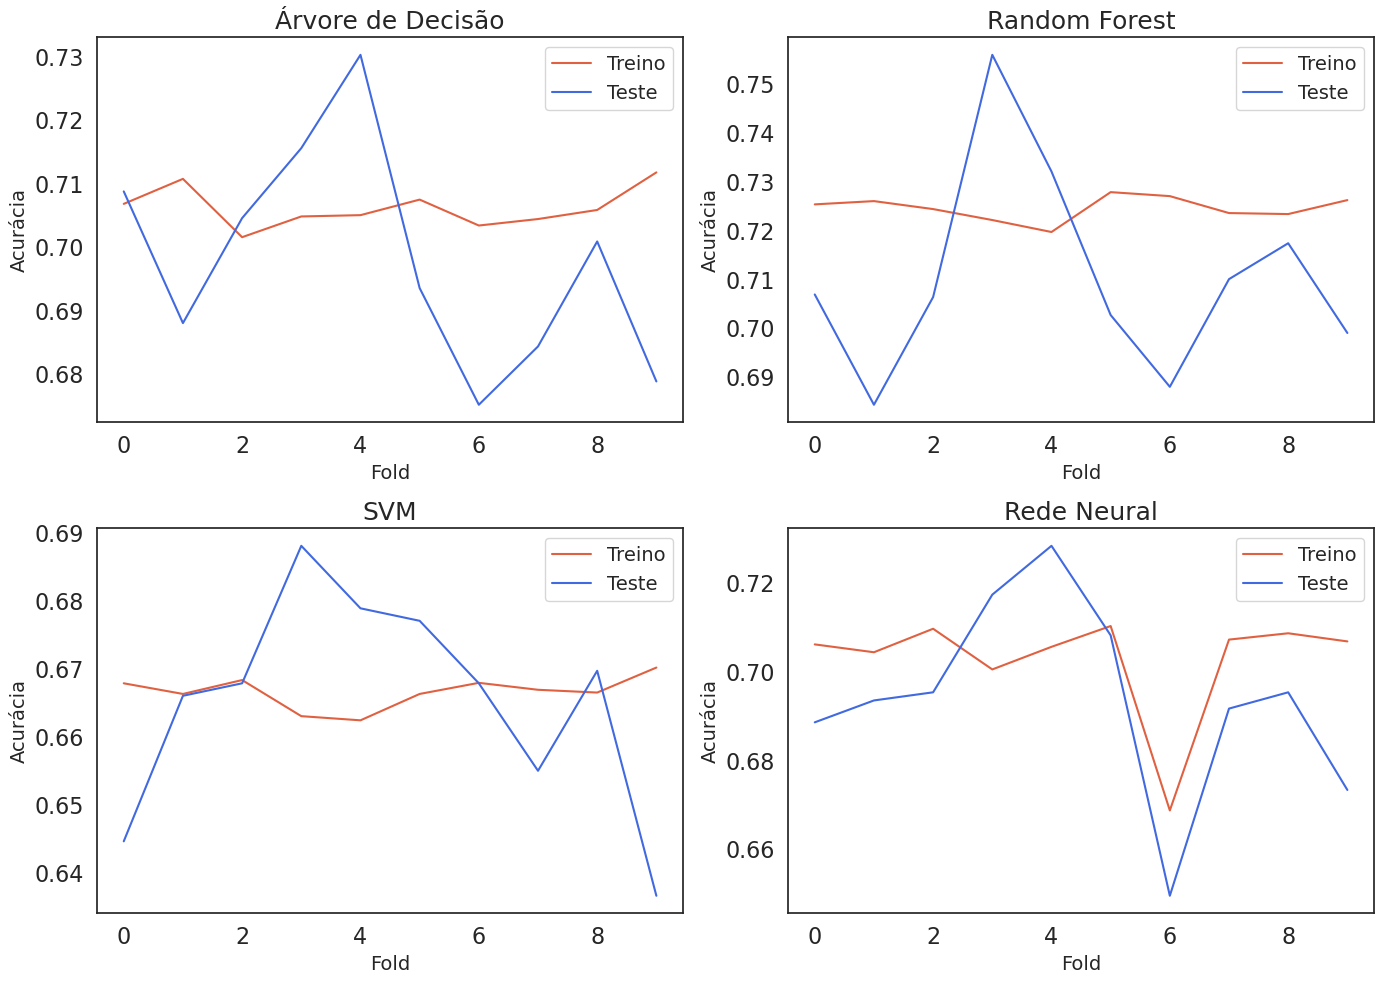

In [139]:
models = ["decisionTree", "randomForest", "svm", "redeNeural"]
models_nome = ["Árvore de Decisão", "Random Forest", "SVM", "Rede Neural"]

visualizacao.plot_learning_curve(
    resultados_comp,
    models=models,
    model_names=models_nome,
    save_path="../imagens/curva_aprendizadoML1.pdf",
)

In [ ]:
resultados_comp_teste.mean()

In [ ]:
resultados_comp_teste.columns = [
    "Árvore de Decisão",
    "Random Forest",
    "SVM",
    "Rede Neural",
]

In [ ]:
resultados_comp_teste

In [ ]:
resultados_comp_treino = resultados_comp.loc[
    :, ["decisionTree_treino", "randomForest_treino", "svm_treino", "redeNeural_treino"]
]

In [ ]:
resultados_comp_treino.columns = [
    "Árvore de Decisão",
    "Random Forest",
    "SVM",
    "Rede Neural",
]

In [ ]:
resultados_comp_treino.mean()

In [ ]:
(resultados_comp.std() / resultados_comp.mean()) * 100

Teste de normalidade

In [ ]:
alpha = 0.05

In [ ]:
from scipy.stats import shapiro

In [ ]:
shapiro(resultados_arvore_comp[0]["test_score"]), shapiro(
    resultados_random_forest_comp[0]["test_score"]
), shapiro(resultados_svm_comp[0]["test_score"]), shapiro(
    resultados_rede_neural_comp[0]["test_score"]
)

Teste de hipótese com ANOVA e Tukey

In [ ]:
from scipy.stats import f_oneway

In [ ]:
_, p = f_oneway(
    resultados_arvore_comp[0]["test_score"],
    resultados_random_forest_comp[0]["test_score"],
    resultados_svm_comp[0]["test_score"],
    resultados_rede_neural_comp[0]["test_score"],
)
p

In [ ]:
alpha = 0.05
if p <= alpha:
    print("Hipótese nula rejeitada. Dados são diferentes")
else:
    print("Hipótese alternativa rejeitada. Resultados são iguais")

In [ ]:
resultados_algoritmos_comp = {
    "accuracy": np.concatenate(
        [
            resultados_arvore_comp[0]["test_score"],
            resultados_random_forest_comp[0]["test_score"],
            resultados_svm_comp[0]["test_score"],
            resultados_rede_neural_comp[0]["test_score"],
        ]
    ),
    "algoritmo": ["arvore"] * len(resultados_arvore_comp[0]["test_score"])
    + ["random_forest"] * len(resultados_random_forest_comp[0]["test_score"])
    + ["svm"] * len(resultados_svm_comp[0]["test_score"])
    + ["rede_neural"] * len(resultados_rede_neural_comp[0]["test_score"]),
}

In [ ]:
resultados_df_comp = pd.DataFrame(resultados_algoritmos_comp)
resultados_df_comp

In [ ]:
!pip install statsmodels

In [ ]:
from statsmodels.stats.multicomp import MultiComparison

In [ ]:
compara_algoritmos_comp = MultiComparison(
    resultados_df_comp["accuracy"], resultados_df_comp["algoritmo"]
)

In [ ]:
teste_estatistico_comp = compara_algoritmos_comp.tukeyhsd()
print(teste_estatistico_comp)

In [ ]:
resultados_comp_teste.mean()

In [ ]:
teste_estatistico_comp.plot_simultaneous();

Salvar o classificador treinado

In [ ]:
# classificador_randomForest = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
#                        n_estimators=200, n_jobs=-1, random_state=42,
#                        warm_start=True)
# classificador_randomForest.fit(x_poscomp, y_poscomp)

In [ ]:
import pickle

pickle.dump(classificador_randomForest, open("randomForest_finalizado.sav", "wb"))

Carregar um classificar treinado

In [ ]:
randomForest = pickle.load(open("randomForest_finalizado.sav", "rb"))

##### Algoritmos para computação

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

algorithms = [
    ("Árvore de Decisão (C4.5)", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42, n_estimators=1000)),
    ("SVM", SVC(random_state=42)),
    ("Rede Neural", MLPClassifier(random_state=42)),
]

for name, classifier in algorithms:
    classifier.fit(x_train_comp, y_train_comp)
    train_predictions_comp = classifier.predict(x_train_comp)
    test_predictions_comp = classifier.predict(x_test_comp)

    train_accuracy_comp = accuracy_score(y_train_comp, train_predictions_comp)
    test_accuracy_comp = accuracy_score(y_test_comp, test_predictions_comp)

    precision_comp = precision_score(
        y_test_comp, test_predictions_comp, average="macro"
    )
    recall_comp = recall_score(y_test_comp, test_predictions_comp, average="macro")
    f1_comp = f1_score(y_test_comp, test_predictions_comp, average="macro")

    conf_matrix_comp = confusion_matrix(y_test_comp, test_predictions_comp)

    print(
        f"{name} - Acurácia no Conjunto de Treinamento: {train_accuracy_comp * 100:.2f}%"
    )
    print(f"{name} - Acurácia no Conjunto de Teste: {test_accuracy_comp * 100:.2f}%")
    print(f"{name} - Precisão: {precision_comp * 100:.2f}%")
    print(f"{name} - Recall: {recall_comp * 100:.2f}%")
    print(f"{name} - F1-Score: {f1_comp * 100:.2f}%")
    print(f"{name} - Matriz de Confusão:\n{conf_matrix_comp}\n")

### Candidates classified for the information area

In [140]:
df_information = dataset[dataset["area_concentration"] == "informatica"]

In [141]:
df_information = df_information.loc[
    :,
    [
        "IDADE",
        "SEXO",
        "REGIAO",
        "ESTADO",
        "matematica",
        "fund_computacao",
        "tec_computacao",
        "total",
        "linhas_pesquisas",
    ],
]

In [142]:
categorical_columns_inf = ["linhas_pesquisas", "SEXO", "REGIAO", "ESTADO"]
df_information = encode_categorical_columns(df_information, categorical_columns_inf)

In [143]:
x_information = df_information.drop(["linhas_pesquisas"], axis=1)
y_information = df_information["linhas_pesquisas"]

Dividir a Base

In [144]:
x_train_inf, x_test_inf, y_train_inf, y_test_inf = train_test_split(
    x_information, y_information, test_size=0.3, stratify=y_information
)

In [145]:
print("Shape of x_train : ", x_train_inf.shape)
print("Shape of x_test  : ", x_test_inf.shape)
print("Shape of y_train : ", y_train_inf.shape)
print("Shape of y_test  : ", y_test_inf.shape)

Shape of x_train :  (2213, 8)
Shape of x_test  :  (949, 8)
Shape of y_train :  (2213,)
Shape of y_test  :  (949,)


###### Arvore de Decisão

In [169]:
parametros = {
    "criterion": ["entropy", "log_loss", "gini"],
    "splitter": ["random", "best"],
    "max_depth": [3, 4, 5, 6, 7],  # Ou qualquer outro intervalo apropriado
    'min_samples_split': [2, 5, 10],
    "min_samples_leaf": np.arange(1, 21, 2),
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    "max_features": [4, 5, 6],
    'max_leaf_nodes': [None, 5, 10, 20],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],
    # 'ccp_alpha': [0.0, 0.1, 0.2],
}

In [170]:
tree_clf = ClassifierWrapper(DecisionTreeClassifier(random_state=42), parametros)
tree_clf.grid_search(x_train_inf, y_train_inf, cv=10)
tree_clf.train_and_print_scores(x_train_inf, y_train_inf, x_test_inf, y_test_inf)

Best Parameters:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 6, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 10, 'splitter': 'best'}
Best Score:
0.6936182789123966
Best Estimator:
DecisionTreeClassifier(max_depth=5, max_features=6, min_samples_leaf=3,
                       min_samples_split=10, random_state=42)
Train Result:
Accuracy Score: 70.63%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.699738    0.746753  0.706281     0.723245      0.716776
recall        0.944720    0.286783  0.706281     0.615752      0.706281
f1-score      0.803981    0.414414  0.706281     0.609198      0.662800
support    1411.000000  802.000000  0.706281  2213.000000   2213.000000
__________________________________________________________________________
Confusion Matrix: 
 [[1333   78]
 [ 572  230]]

Test Result:
Accuracy Score: 67.86%

In [171]:
process_cv_results(tree_clf.cv_results_, top_n=10, output_filename='df_em_porcentes_treeM2.csv')

,param_criterion,param_max_depth,param_max_features,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,param_splitter,mean_test_score,mean_train_score
9131,gini,5,6,None,3,10,best,69.36%,70.35%
1659,entropy,5,4,20,13,5,best,69.05%,69.93%
9125,gini,5,6,None,1,10,best,69.00%,70.43%
1667,entropy,5,4,20,15,10,best,68.91%,69.74%
925,entropy,4,4,20,9,2,best,68.87%,69.33%
9129,gini,5,6,None,3,5,best,68.87%,70.34%
4541,log_loss,4,4,20,13,10,best,68.87%,69.41%
10273,gini,7,4,20,5,2,best,68.86%,70.30%
4533,log_loss,4,4,20,11,5,best,68.82%,69.37%
947,entropy,4,4,20,15,10,best,68.82%,69.38%


###### Random Forest

In [184]:
parametros = {
    "n_estimators": [300,500,600,700],
    "criterion": ['gini', 'entropy', 'log_loss'],
    "max_depth": [6,7,8,9],
    'min_samples_split': [2,4,6],
    "min_samples_leaf": [8,9,10],
    # 'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    "max_features": ['sqrt', 'log2', None],
    'max_leaf_nodes': [None, 20, 30],
    # 'min_impurity_decrease': [0.0, 0.1, 0.2],
    "bootstrap": [False, True],
    # 'oob_score': [True, False],
    "n_jobs": [-1],  # Use -1 para usar todos os processadores disponíveis
    # 'verbose': [0, 1, 2],
    # 'warm_start': [True],
    # 'class_weight': ['balanced'],
    # 'ccp_alpha': [0.0, 0.1, 0.2],
    # 'max_samples': [None, 0.7, 0.8, 0.9],
}

In [185]:
forest_clf = ClassifierWrapper(RandomForestClassifier(random_state=42), parametros)
forest_clf.grid_search(x_train_inf, y_train_inf, cv=10)
forest_clf.train_and_print_scores(x_train_inf, y_train_inf, x_test_inf, y_test_inf)

KeyboardInterrupt: 

In [ ]:
process_cv_results(forest_clf.cv_results_, top_n=10, output_filename='df_em_porcentes_forestM2.csv')

###### SVM

In [ ]:
parametros = {
    "C": [1, 2, 3, 4],
    "kernel": ["poly", "rbf"],
    "degree": [5, 6, 7, 8],
    # 'gamma': ['scale', 'auto'],
    # "coef0": [0.1, 1.0],
    # 'shrinking': [True, False],
    # 'probability': [True],
    # 'tol': [1e-4],
    # 'cache_size': np.arange(1,11,2),
    # "class_weight": [None, "balanced"],
    # 'verbose': [True],
    # 'max_iter': [100, 1000, -1],  # -1 indica nenhum limite
    # 'decision_function_shape': ['ovr', 'ovo'],
    # 'break_ties': [True],
}

In [ ]:
svm_clf = ClassifierWrapper(SVC(random_state=42), parametros)
svm_clf.grid_search(x_train_inf, y_train_inf, cv=10)
svm_clf.train_and_print_scores(x_train_inf, y_train_inf, x_test_inf, y_test_inf)

In [ ]:
process_cv_results(svm_clf.cv_results_, top_n=10, output_filename='df_em_porcentes_svmM2.csv')

##### Rede Neural

In [181]:
parametros = {
    "hidden_layer_sizes": [(50,), (100,), (50, 50), (100, 100), (200, 100, 50)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    "solver": ['lbfgs', 'sgd', 'adam'],
    "alpha": [0.01, 0.001, 0.0001],
    # "batch_size": ["auto", 100, 200],
    # 'learning_rate': ['constant', 'invscaling', 'adaptive'],
    # "learning_rate_init": [0.01],
    # 'power_t': [0.5, 0.9],
    'max_iter': [2000,2500,3000],
    # 'shuffle': [True, False],
    # 'random_state': [None, 42],
    # 'tol': [1e-4, 1e-3, 1e-2],
    # 'verbose': [True, False],
    # 'warm_start': [True, False],
    # 'momentum': [0.5, 0.9],
    # 'nesterovs_momentum': [True, False],
    # "early_stopping": [True, False],
    # 'validation_fraction': [0.1, 0.2],
    # "beta_1": [0.99],
    # "beta_2": [0.999],
    # "epsilon": [1e-8],
    # "n_iter_no_change": [20],
    # 'max_fun': [10000, 15000, 20000]
}

In [182]:
neural_clf = ClassifierWrapper(MLPClassifier(random_state=42), parametros)
neural_clf.grid_search(x_train_inf, y_train_inf, cv=10)
neural_clf.train_and_print_scores(x_train_inf, y_train_inf, x_test_inf, y_test_inf)

/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jean/anaconda3/envs/poscomp/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning:

Best Parameters:
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'max_iter': 2000, 'solver': 'adam'}
Best Score:
0.669234845705434
Best Estimator:
MLPClassifier(activation='tanh', hidden_layer_sizes=(100, 100), max_iter=2000,
              random_state=42)
Train Result:
Accuracy Score: 70.27%
__________________________________________________________________________
CLASSIFICATION REPORT:
                     0           1  accuracy    macro avg  weighted avg
precision     0.713799    0.659292  0.702666     0.686546      0.694045
recall        0.890858    0.371571  0.702666     0.631214      0.702666
f1-score      0.792560    0.475279  0.702666     0.633920      0.677576
support    1411.000000  802.000000  0.702666  2213.000000   2213.000000
__________________________________________________________________________
Confusion Matrix: 
 [[1257  154]
 [ 504  298]]

Test Result:
Accuracy Score: 67.86%
_______________________________________________________________

In [183]:
process_cv_results(neural_clf.cv_results_, top_n=10, output_filename='df_em_porcentes_neuralM2.csv')

,param_activation,param_alpha,param_hidden_layer_sizes,param_max_iter,param_solver,mean_test_score,mean_train_score
392,tanh,0.0001,"(100, 100)",2500,adam,66.92%,70.31%
317,tanh,0.001,"(50,)",2000,adam,66.88%,69.74%
176,logistic,0.01,"(200, 100, 50)",2500,adam,66.88%,66.19%
362,tanh,0.0001,"(50,)",2000,adam,66.83%,69.92%
453,relu,0.001,"(50,)",2500,lbfgs,66.79%,71.14%
275,tanh,0.01,"(50,)",2500,adam,66.74%,69.61%
450,relu,0.001,"(50,)",2000,lbfgs,66.74%,70.68%
299,tanh,0.01,"(100, 100)",2000,adam,66.70%,70.25%
538,relu,0.0001,"(200, 100, 50)",3000,sgd,66.70%,66.98%
221,logistic,0.001,"(200, 100, 50)",2500,adam,66.70%,66.20%


##### Validação Cruzada

In [68]:
x_poscomp_inf = np.concatenate((x_train_inf, x_test_inf), axis=0)
y_poscomp_inf = np.concatenate((y_train_inf, y_test_inf), axis=0)

In [69]:
# Uso para Decision Tree
params_arvore_inf = {
    "criterion": "entropy",
    "max_depth": 10,
    "max_features": 4,
    "min_samples_leaf": 2,
    "random_state": 42,
    "splitter": "random",
}
resultados_arvore_inf = ClassifierWrapper.avaliar_classificador(
    DecisionTreeClassifier, params_arvore_inf, x_poscomp_inf, y_poscomp_inf
)

# Uso para Random Forest
params_random_forest_inf = {
    "bootstrap": False,
    "criterion": "entropy",
    "max_depth": 8,
    "max_features": "sqrt",
    "min_samples_leaf": 9,
    "n_estimators": 600,
    "n_jobs": -1,
    "random_state": 42,
}
resultados_random_forest_inf = ClassifierWrapper.avaliar_classificador(
    RandomForestClassifier, params_random_forest_inf, x_poscomp_inf, y_poscomp_inf
)

# Uso para SVM
params_svm_inf = {
    "C": 4,
    "degree": 7,
    "kernel": "poly",
    "random_state": 42,
}
resultados_svm_inf = ClassifierWrapper.avaliar_classificador(
    SVC, params_svm_inf, x_poscomp_inf, y_poscomp_inf
)

# Uso para MLP (Rede Neural)
params_rede_neural_inf = {
    "activation": "logistic",
    "alpha": 1e-05,
    "batch_size": 50,
    "hidden_layer_sizes": (200, 100, 50),
    "learning_rate": "constant",
    "learning_rate_init": 0.001,
    "max_iter": 70,
    "solver": "adam",
    "random_state": 42,
}
resultados_rede_neural_inf = ClassifierWrapper.avaliar_classificador(
    MLPClassifier, params_rede_neural_inf, x_poscomp_inf, y_poscomp_inf
)

In [186]:
# Supondo que x_train, x_test, y_train, y_test são seus dados de treino e teste

# Para a Árvore de Decisão
matriz_confusao_arvore_inf = ClassifierWrapper.gerar_matriz_confusao(
    DecisionTreeClassifier, params_arvore_inf, x_train, x_test, y_train, y_test
)

# Para a Random Forest
matriz_confusao_random_forest_inf = ClassifierWrapper.gerar_matriz_confusao(
    RandomForestClassifier, params_random_forest_inf, x_train, x_test, y_train, y_test
)

# Para o SVM
matriz_confusao_svm_inf = ClassifierWrapper.gerar_matriz_confusao(
    SVC, params_svm_inf, x_train, x_test, y_train, y_test
)

# Para a Rede Neural
matriz_confusao_rede_neural_inf = ClassifierWrapper.gerar_matriz_confusao(
    MLPClassifier, params_rede_neural_inf, x_train, x_test, y_train, y_test
)

KeyboardInterrupt: 

In [187]:
resultados_inf = pd.DataFrame(
    {
        "decisionTree_treino": resultados_arvore_inf[0]["train_score"],
        "decisionTree_teste": resultados_arvore_inf[0]["test_score"],
        "randomForest_treino": resultados_random_forest_inf[0]["train_score"],
        "randomForest_teste": resultados_random_forest_inf[0]["test_score"],
        "svm_treino": resultados_svm_inf[0]["train_score"],
        "svm_teste": resultados_svm_inf[0]["test_score"],
        "redeNeural_treino": resultados_rede_neural_inf[0]["train_score"],
        "redeNeural_teste": resultados_rede_neural_inf[0]["test_score"],
    }
)

In [188]:
resultados_inf

,decisionTree_treino,decisionTree_teste,randomForest_treino,randomForest_teste,svm_treino,svm_teste,redeNeural_treino,redeNeural_teste
0,0.723726,0.659306,0.739192,0.668770,0.724780,0.662461,0.675220,0.662461
1,0.733919,0.678233,0.734622,0.681388,0.716696,0.678233,0.688225,0.649842
2,0.738580,0.661392,0.744554,0.693038,0.718904,0.693038,0.673928,0.670886
3,0.729796,0.664557,0.735418,0.699367,0.717850,0.686709,0.685172,0.708861
4,0.734715,0.731013,0.733661,0.718354,0.717498,0.712025,0.671820,0.715190
5,0.734715,0.677215,0.740337,0.683544,0.720661,0.696203,0.665847,0.664557
6,0.728039,0.674051,0.736824,0.715190,0.717147,0.696203,0.686578,0.677215
7,0.737526,0.607595,0.739986,0.658228,0.724174,0.632911,0.679199,0.655063
8,0.713633,0.696203,0.737526,0.702532,0.714336,0.718354,0.683064,0.677215
9,0.734364,0.655063,0.738580,0.689873,0.721012,0.670886,0.676388,0.670886


In [189]:
medias = resultados_inf.mean()
for nome_coluna, media in medias.items():
    print(f"Média da {nome_coluna}: {media * 100:.2f}%")

Média da decisionTree_treino: 73.09%
Média da decisionTree_teste: 67.05%
Média da randomForest_treino: 73.81%
Média da randomForest_teste: 69.10%
Média da svm_treino: 71.93%
Média da svm_teste: 68.47%
Média da redeNeural_treino: 67.85%
Média da redeNeural_teste: 67.52%


In [190]:
resultados_inf_teste = resultados_inf.loc[
    :, ["decisionTree_teste", "randomForest_teste", "svm_teste", "redeNeural_teste"]
]

In [191]:
resultados_inf_teste.mean()

decisionTree_teste    0.670463
randomForest_teste    0.691028
svm_teste             0.684702
redeNeural_teste      0.675218
dtype: float64

In [192]:
resultados_inf_teste.columns = [
    "Árvore de Decisão",
    "Random Forest",
    "SVM",
    "Rede Neural",
]

In [193]:
resultados_inf_teste

,Árvore de Decisão,Random Forest,SVM,Rede Neural
0,0.659306,0.668770,0.662461,0.662461
1,0.678233,0.681388,0.678233,0.649842
2,0.661392,0.693038,0.693038,0.670886
3,0.664557,0.699367,0.686709,0.708861
4,0.731013,0.718354,0.712025,0.715190
5,0.677215,0.683544,0.696203,0.664557
6,0.674051,0.715190,0.696203,0.677215
7,0.607595,0.658228,0.632911,0.655063
8,0.696203,0.702532,0.718354,0.677215
9,0.655063,0.689873,0.670886,0.670886


In [194]:
resultados_inf_treino = resultados_inf.loc[
    :, ["decisionTree_treino", "randomForest_treino", "svm_treino", "redeNeural_treino"]
]

In [195]:
resultados_inf_treino.columns = [
    "Árvore de Decisão",
    "Random Forest",
    "SVM",
    "Rede Neural",
]

In [196]:
resultados_inf_treino.mean()

Árvore de Decisão    0.730902
Random Forest        0.738070
SVM                  0.719306
Rede Neural          0.678544
dtype: float64

In [197]:
(resultados_inf.std() / resultados_inf.mean()) * 100

decisionTree_treino    1.032083
decisionTree_teste     4.684696
randomForest_treino    0.434539
randomForest_teste     2.753328
svm_treino             0.463735
svm_teste              3.651793
redeNeural_treino      1.061011
redeNeural_teste       3.161651
dtype: float64

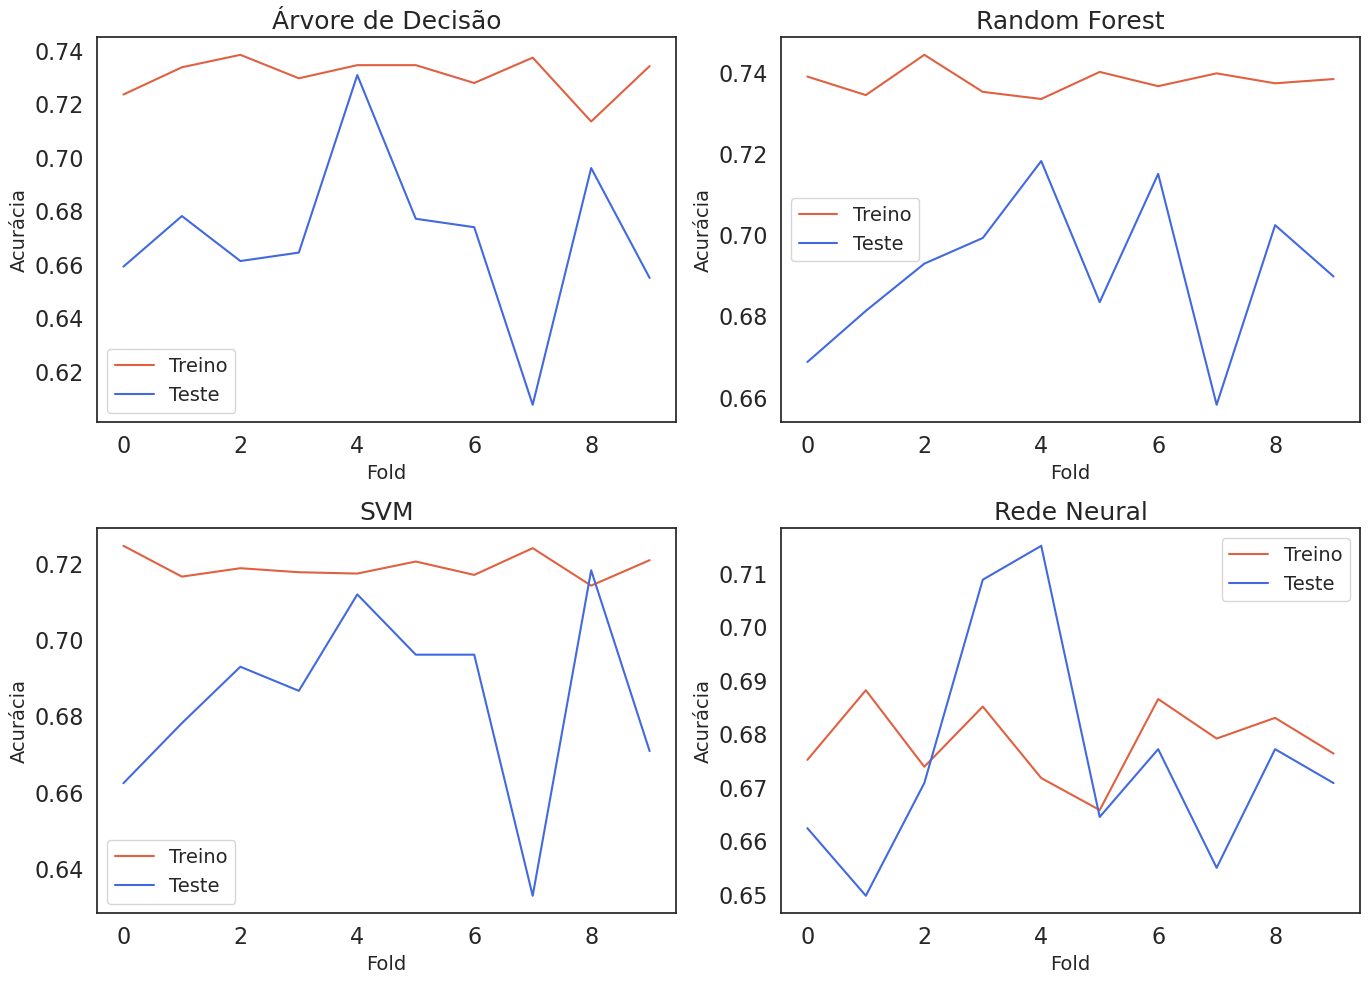

In [198]:
visualizacao.plot_learning_curve(
    resultados_inf,
    models=models,
    model_names=models_nome,
    save_path="../imagens/curva_aprendizadoML2.pdf",
)

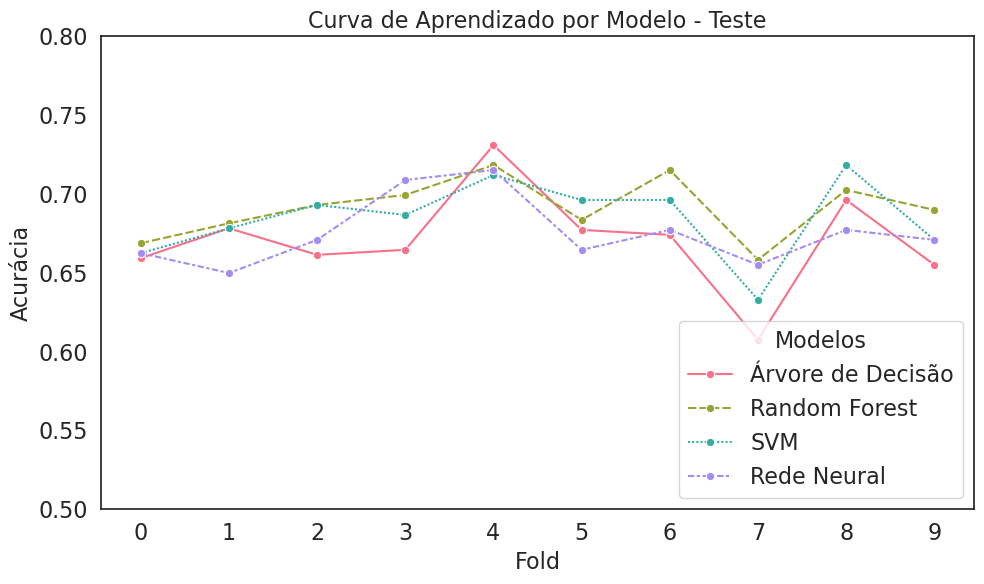

In [199]:
visualizacao.line_plot(
    resultados_inf_teste,
    title_plot="Curva de Aprendizado por Modelo - Teste",
    xlabel="Fold",
    ylabel="Acurácia",
    save_path="../imagens/curva_aprend_ML2_teste.png",
    legend_title="Modelos",
)

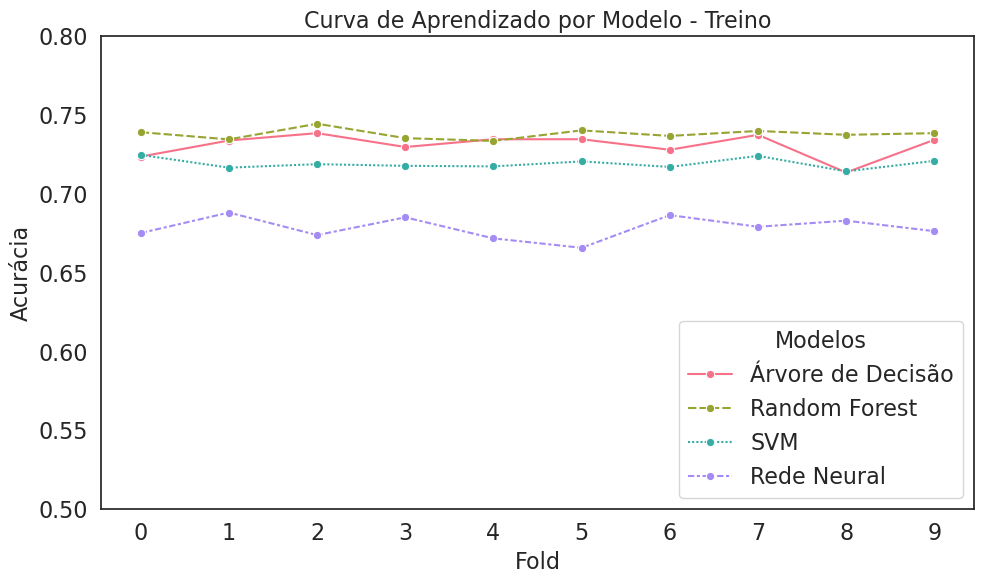

In [200]:
visualizacao.line_plot(
    resultados_inf_treino,
    title_plot="Curva de Aprendizado por Modelo - Treino",
    xlabel="Fold",
    ylabel="Acurácia",
    save_path="../imagens/curva_aprend_ML2_treino.png",
    legend_title="Modelos",
)

Teste de normalidade

In [ ]:
from scipy.stats import shapiro

In [ ]:
shapiro(resultados_arvore_inf[0]["test_score"]), shapiro(
    resultados_random_forest_inf[0]["test_score"]
), shapiro(resultados_svm_inf[0]["test_score"]), shapiro(
    resultados_rede_neural_inf[0]["test_score"]
)

Teste de hipótese com ANOVA e Tukey

In [ ]:
from scipy.stats import f_oneway

In [ ]:
_, p_inf = f_oneway(
    resultados_arvore_inf[0]["test_score"],
    resultados_random_forest_inf[0]["test_score"],
    resultados_svm_inf[0]["test_score"],
    resultados_rede_neural_inf[0]["test_score"],
)
p_inf

In [ ]:
alpha = 0.05
if p_inf <= alpha:
    print("Hipótese nula rejeitada. Dados são diferentes")
else:
    print("Hipótese alternativa rejeitada. Resultados são iguais")

In [ ]:
resultados_algoritmos_inf = {
    "accuracy": np.concatenate(
        [
            resultados_arvore_inf[0]["test_score"],
            resultados_random_forest_inf[0]["test_score"],
            resultados_svm_inf[0]["test_score"],
            resultados_rede_neural_inf[0]["test_score"],
        ]
    ),
    "algoritmo": ["arvore"] * len(resultados_arvore_inf[0]["test_score"])
    + ["random_forest"] * len(resultados_random_forest_inf[0]["test_score"])
    + ["svm"] * len(resultados_svm_inf[0]["test_score"])
    + ["rede_neural"] * len(resultados_rede_neural_inf[0]["test_score"]),
}

In [ ]:
resultados_df_inf = pd.DataFrame(resultados_algoritmos_inf)

In [ ]:
resultados_df_inf["algoritmo"] = resultados_df_inf["algoritmo"].replace(
    {
        "arvore": "Árvore de Decisão",
        "random_forest": "Random Forest",
        "svm": "SVM",
        "rede_neural": "Rede Neural",
    }
)

In [ ]:
resultados_df_inf.head()

In [ ]:
from statsmodels.stats.multicomp import MultiComparison

In [ ]:
compara_algoritmos_inf = MultiComparison(
    resultados_df_inf["accuracy"], resultados_df_inf["algoritmo"]
)

In [ ]:
teste_estatistico_inf = compara_algoritmos_inf.tukeyhsd()
print(teste_estatistico_inf)

In [ ]:
ax = teste_estatistico_inf.plot_simultaneous()
ax.savefig("../imagens/comparacionML2.png")

In [ ]:
resultados_inf_teste.mean()

##### Algoritmos para informação

In [ ]:
algorithms = [
    ("Árvore de Decisão (C4.5)", DecisionTreeClassifier(random_state=42)),
    ("Random Forest", RandomForestClassifier(random_state=42)),
    ("SVM", SVC(random_state=42)),
    ("Rede Neural", MLPClassifier(random_state=42)),
]

for name, classifier in algorithms:
    classifier.fit(x_train_inf, y_train_inf)
    train_predictions_inf = classifier.predict(x_train_inf)
    test_predictions_inf = classifier.predict(x_test_inf)

    train_accuracy_inf = accuracy_score(y_train_inf, train_predictions_inf)
    test_accuracy_inf = accuracy_score(y_test_inf, test_predictions_inf)

    precision_inf = precision_score(y_test_inf, test_predictions_inf, average="macro")
    recall_inf = recall_score(y_test_inf, test_predictions_inf, average="macro")
    f1_inf = f1_score(y_test_inf, test_predictions_inf, average="macro")

    conf_matrix_inf = confusion_matrix(y_test_inf, test_predictions_inf)

    print(
        f"{name} - Acurácia no Conjunto de Treinamento: {train_accuracy_inf * 100:.2f}%"
    )
    print(f"{name} - Acurácia no Conjunto de Teste: {test_accuracy_inf * 100:.2f}%")
    print(f"{name} - Precisão: {precision_inf * 100:.2f}%")
    print(f"{name} - Recall: {recall_inf * 100:.2f}%")
    print(f"{name} - F1-Score: {f1_inf * 100:.2f}%")
    print(f"{name} - Matriz de Confusão:\n{conf_matrix_inf}\n")

### Os algoritmos

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)

algorithms = [
    (
        "Árvore de Decisão (C4.5)",
        DecisionTreeClassifier(
            criterion="entropy", max_depth=4, min_samples_leaf=6, random_state=42
        ),
    ),
    (
        "Random Forest",
        RandomForestClassifier(
            bootstrap=False,
            criterion="entropy",
            max_depth=10,
            n_estimators=200,
            n_jobs=-1,
            random_state=42,
            warm_start=True,
        ),
    ),
    (
        "SVM",
        SVC(
            C=5000,
            break_ties=True,
            degree=1,
            probability=True,
            random_state=42,
            tol=0.0001,
            verbose=True,
        ),
    ),
    (
        "Rede Neural",
        MLPClassifier(
            activation="tanh", hidden_layer_sizes=(100, 100), random_state=42
        ),
    ),
]

for name, classifier in algorithms:
    classifier.fit(x_train, y_train)
    train_predictions = classifier.predict(x_train)
    test_predictions = classifier.predict(x_test)

    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)

    precision = precision_score(y_test, test_predictions, average="macro")
    recall = recall_score(y_test, test_predictions, average="macro")
    f1 = f1_score(y_test, test_predictions, average="macro")

    conf_matrix = confusion_matrix(y_test, test_predictions)

    print(f"{name} - Acurácia no Conjunto de Treinamento: {train_accuracy * 100:.2f}%")
    print(f"{name} - Acurácia no Conjunto de Teste: {test_accuracy * 100:.2f}%")
    print(f"{name} - Precisão: {precision * 100:.2f}%")
    print(f"{name} - Recall: {recall * 100:.2f}%")
    print(f"{name} - F1-Score: {f1 * 100:.2f}%")
    print(f"{name} - Matriz de Confusão:\n{conf_matrix}\n")